<a href="https://colab.research.google.com/github/oochuru/MLBootCamp25Ochuru/blob/main/9_MLBootcamp_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Bootcamp 2025

### Final Project: Train a Deep Learning model to identify Grocery item

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import csv
from datetime import datetime

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# NOTE: Create directory 'Datasets/GroceryStoreDataset', unzip the shared dataset in it and mount the Google Drive
# The original dataset used is: https://www.kaggle.com/datasets/validmodel/grocery-store-dataset?resource=download and it has been reduced further for our use-case
data_dir = '/content/drive/MyDrive/GroceryStoreDataset'  # Mount dataset in Google Drive

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda:0


In [21]:
def extract_class_names(csv_file_path):
    """
    Extracts class names from a CSV file and returns them as a list.

    Args:
        csv_file_path (str): The path to the CSV file.

    Returns:
        tuple: A tuple containing a list of class names and the number of classes.
               Returns (None, 0) if the file does not exist or an error occurs.
    """
    try:
        with open(csv_file_path, 'r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header row if it exists
            class_names = [row[2] for row in reader]  # Assuming class names are in the first column
            class_names = sorted(set(class_names))
        return class_names, len(class_names)

    except FileNotFoundError:
        print(f"Error: File '{csv_file_path}' not found.")
        return None, 0
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, 0

In [22]:
# Data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [23]:
# Identify that all folders are accessible from mounted Google Drive
for x in ['train', 'test']:
  path_new = os.path.join(data_dir, x)
  print(path_new)
  for folder in os.listdir(path_new):
    folder_path = os.path.join(path_new, folder)
    print(folder_path)


/content/drive/MyDrive/GroceryStoreDataset/train
/content/drive/MyDrive/GroceryStoreDataset/train/Avocado
/content/drive/MyDrive/GroceryStoreDataset/train/Granny-Smith
/content/drive/MyDrive/GroceryStoreDataset/train/Red-Delicious
/content/drive/MyDrive/GroceryStoreDataset/train/Banana
/content/drive/MyDrive/GroceryStoreDataset/train/Pomegranate
/content/drive/MyDrive/GroceryStoreDataset/train/Passion-Fruit
/content/drive/MyDrive/GroceryStoreDataset/train/Nectarine
/content/drive/MyDrive/GroceryStoreDataset/train/Lemon
/content/drive/MyDrive/GroceryStoreDataset/train/Papaya
/content/drive/MyDrive/GroceryStoreDataset/train/Plum
/content/drive/MyDrive/GroceryStoreDataset/train/Lime
/content/drive/MyDrive/GroceryStoreDataset/train/Kiwi
/content/drive/MyDrive/GroceryStoreDataset/train/Red-Grapefruit
/content/drive/MyDrive/GroceryStoreDataset/train/Pineapple
/content/drive/MyDrive/GroceryStoreDataset/train/Cantaloupe
/content/drive/MyDrive/GroceryStoreDataset/train/Orange
/content/drive/MyD

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}  # Assuming you have train and test folders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

print(f"Dataset sizes: {dataset_sizes}")

Dataset sizes: {'train': 1236, 'test': 1205}


In [25]:
class_names = image_datasets['train'].classes

print(class_names)
print(len(class_names))

class_names = image_datasets['test'].classes

print(class_names)
print(len(class_names))

num_classes = len(class_names)

['Asparagus', 'Avocado', 'Banana', 'Cabbage', 'Cantaloupe', 'Carrots', 'Cucumber', 'Garlic', 'Ginger', 'Granny-Smith', 'Kiwi', 'Leek', 'Lemon', 'Lime', 'Mango', 'Nectarine', 'Orange', 'Papaya', 'Passion-Fruit', 'Peach', 'Pepper', 'Pineapple', 'Plum', 'Pomegranate', 'Red-Beet', 'Red-Delicious', 'Red-Grapefruit', 'Regular-Tomato', 'Solid-Potato', 'Sweet-Potato', 'Vine-Tomato', 'Watermelon', 'Yellow-Onion', 'Zucchini']
34
['Asparagus', 'Avocado', 'Banana', 'Cabbage', 'Cantaloupe', 'Carrots', 'Cucumber', 'Garlic', 'Ginger', 'Granny-Smith', 'Kiwi', 'Leek', 'Lemon', 'Lime', 'Mango', 'Nectarine', 'Orange', 'Papaya', 'Passion-Fruit', 'Peach', 'Pepper', 'Pineapple', 'Plum', 'Pomegranate', 'Red-Beet', 'Red-Delicious', 'Red-Grapefruit', 'Regular-Tomato', 'Solid-Potato', 'Sweet-Potato', 'Vine-Tomato', 'Watermelon', 'Yellow-Onion', 'Zucchini']
34


In [26]:
# Load pre-trained EfficientNetB4
model = models.efficientnet_b4(pretrained=True)

# Modify the classifier
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 88.9MB/s]


In [27]:
def predict_image(image_path, model, class_names):
  img = Image.open(image_path).convert('RGB')
  img_t = data_transforms['test'](img).unsqueeze(0)
  img_t = img_t.to(device)
  model.eval()
  with torch.no_grad():
    out = model(img_t)
    _, index = torch.max(out, 1)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    print(f"Predicted Class: {class_names[index[0]]}, Confidence: {percentage[index[0]].item():.2f}%")

In [28]:
def train_model(model, criterion, optimizer, num_epochs=25):
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        now = datetime.now()
        print(now.strftime("%Y-%m-%d %H:%M:%S"))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            i = 0
            for inputs, labels in dataloaders[phase]:
                i += 1
                if i % 10 == 0:
                    print(f"Batch {i} of {len(dataloaders[phase])}")
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

    return model, history

In [31]:
# Before training
predict_image('/content/drive/MyDrive/GroceryStoreDataset/test/Mango/Mango_002.jpg', model, class_names)
predict_image('/content/drive/MyDrive/GroceryStoreDataset/test/Pineapple/Pineapple_021.jpg', model, class_names)


Predicted Class: Mango, Confidence: 3.50%
Predicted Class: Pomegranate, Confidence: 3.20%


In [36]:
model, history = train_model(model, criterion, optimizer, num_epochs=15)


Epoch 0/14
2025-04-14 07:12:52
----------
Batch 10 of 78
Batch 20 of 78
Batch 30 of 78
Batch 40 of 78
Batch 50 of 78
Batch 60 of 78
Batch 70 of 78
train Loss: 2.9396 Acc: 0.2338
Batch 10 of 76
Batch 20 of 76
Batch 30 of 76
Batch 40 of 76
Batch 50 of 76
Batch 60 of 76
Batch 70 of 76
test Loss: 2.9349 Acc: 0.2523
Epoch 1/14
2025-04-14 07:13:18
----------
Batch 10 of 78
Batch 20 of 78
Batch 30 of 78
Batch 40 of 78
Batch 50 of 78
Batch 60 of 78
Batch 70 of 78
train Loss: 2.7812 Acc: 0.3147
Batch 10 of 76
Batch 20 of 76
Batch 30 of 76
Batch 40 of 76
Batch 50 of 76
Batch 60 of 76
Batch 70 of 76
test Loss: 2.7631 Acc: 0.3917
Epoch 2/14
2025-04-14 07:13:44
----------
Batch 10 of 78
Batch 20 of 78
Batch 30 of 78
Batch 40 of 78
Batch 50 of 78
Batch 60 of 78
Batch 70 of 78
train Loss: 2.5512 Acc: 0.4005
Batch 10 of 76
Batch 20 of 76
Batch 30 of 76
Batch 40 of 76
Batch 50 of 76
Batch 60 of 76
Batch 70 of 76
test Loss: 2.4247 Acc: 0.4656
Epoch 3/14
2025-04-14 07:14:09
----------
Batch 10 of 78
Batc

{'train_loss': [2.939614772796631, 2.7812333045268134, 2.551223243324502, 2.0431741433621995, 1.664299326807164, 1.4111341365332741, 1.1579991891546157, 0.9830345632960495, 0.8485666540448333, 0.8150723053799478, 0.7197002905472197, 0.654552867497441, 0.6607046181330017, 0.5745520616812227, 0.5038641411509714], 'train_acc': [0.23381877022653721, 0.31472491909385114, 0.4004854368932039, 0.5372168284789645, 0.6270226537216829, 0.6634304207119741, 0.7224919093851133, 0.7580906148867315, 0.7815533980582524, 0.7944983818770227, 0.801779935275081, 0.81957928802589, 0.8131067961165049, 0.8381877022653722, 0.8592233009708738], 'test_loss': [2.9348642671751284, 2.7630943832555745, 2.424689084365655, 1.9400783788119114, 1.5616399621567785, 1.410853544706131, 1.126143759315934, 0.9878109793445381, 0.9988294997155913, 0.8858235310716748, 0.8865179150925633, 0.76755138274545, 0.7175433994823471, 0.7453218286833823, 0.6905418983633588], 'test_acc': [0.25228215767634854, 0.391701244813278, 0.46556016

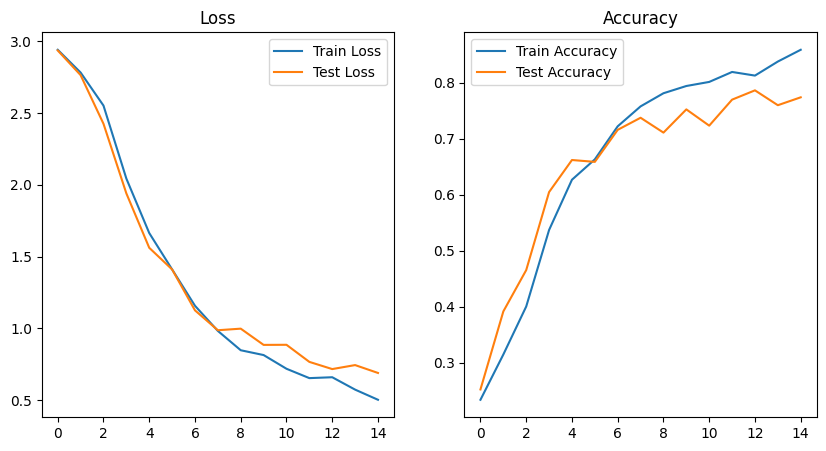

In [37]:
metrics = {
    'train_loss': history['train_loss'],
    'train_acc': [t.cpu().item() for t in history['train_acc']],
    'test_loss': history['test_loss'],
    'test_acc': [t.cpu().item() for t in history['test_acc']]
}

print(metrics)

# Plot the training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['test_loss'], label='Test Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['test_acc'], label='Test Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [38]:
# save the trained model
torch.save(model, '/content/drive/MyDrive/GroceryStoreDataset/complete_model.pth')


In [39]:
# After training
predict_image('/content/drive/MyDrive/GroceryStoreDataset/test/Mango/Mango_002.jpg', model, class_names)
predict_image('/content/drive/MyDrive/GroceryStoreDataset/test/Pineapple/Pineapple_021.jpg', model, class_names)


Predicted Class: Mango, Confidence: 68.51%
Predicted Class: Pineapple, Confidence: 80.23%


### Project:

1. Perform exploratory data analysis on the 'train' and 'test' datasets to calculate class imbalance (by comparing 'samples per class' across all the classes)
2. Print confusion matrix, precision, recall and f1-score
3. Show a grid of 6x4 images, with actual and predicted class for each of those


### Bonus Project:

1. Allow user to input the items they shopped using images, use model to identify grocery item based on confidence threshold. If confidence is low, ask user to manually input the item.
2. Update the digital grocery cart
3. Process the transaction by generating a transaction receipt
